In [48]:
def modelCircle(b, c, d):
  #This funtion take 3 points as input and output the center coordinates and radius of the circle which going through given points
  temp = c[0]**2 + c[1]**2
  bc = (b[0]**2 + b[1]**2 - temp) / 2
  cd = (temp - d[0]**2 - d[1]**2) / 2
  det = (b[0] - c[0]) * (c[1] - d[1]) - (c[0] - d[0]) * (b[1] - c[1])

  if abs(det) < 1.0e-10:
    return None

  # Center of circle
  cx = (bc*(c[1] - d[1]) - cd*(b[1] - c[1])) / det
  cy = ((b[0] - c[0]) * cd - (c[0] - d[0]) * bc) / det

  radius = ((cx - b[0])**2 + (cy - b[1])**2)**.5

  return cx,cy,radius

def shrtDis(points,x,y,r):
    #this funtion caculate distance from given circle to giben points
    #points= numpy array which contain points
    #x,y = coordinate of center of the circle
    #r=raidus
    import numpy as np
    distances= np.array(abs(((points[:,0]-x)**2+(points[:,1]-y)**2)**0.5-r))
    return distances
def plotCiircle(Data,Datalst,color='r'):
    #this fuction plot the circle
    x,y,r=modelCircle(Datalst[Data[0]],Datalst[Data[1]],Datalst[Data[2]])
    c=plt.Circle((x,y),r,fill=False)
    c.set_color(color)
    return c

In [49]:
import numpy as np
from scipy . optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
# np . random. seed ( 0 )
N = 100
half_n = N//2
r = 10
s = r /16
t = np . random. uniform(0 , 2*np . pi , half_n )
n = s*np . random. randn ( half_n )
x , y = ( r + n)*np . cos ( t ) , ( r + n)*np . sin ( t )
X_circ = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
m, b =-1, 2
x = np.linspace(-12, 12 , half_n )
y = m*x + b + s*np . random. randn ( half_n )
X_line = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
X = np . vstack ( ( X_circ , X_line ) )


In [50]:
def ransacCircle(Data,N,t,count):
    #Data= Data set N=Number of iterations 
    # t= threshold distance count=threshold inlier count
    maximum_inlier_count=0
    
    for i in range(N):
        #selecting 3 points randomly
        rndPoints=np.random.choice(len(Data), size=3, replace=False)
        #modelCircle funtion output coordinates and radius of the circle which going through given points
        x,y,r=modelCircle(Data[rndPoints[0]],Data[rndPoints[1]],Data[rndPoints[2]])
        if r>max(Data[:,1])*1.75:#removing extremely large circles
            continue
        #shrDis funtion output the shortest distence between given point set and circle
        distanceLst=shrtDis(Data,x,y,r)
        inliers=Data[distanceLst<t]#finding inliers
        if len(inliers)-3 >count:  #check for threshold inlier count. -3 to remove three randomly slected points         
            shortest_Distance_Of_Inliers=shrtDis(inliers,x,y,r)
            mean_absolute_error = sum(shortest_Distance_Of_Inliers/shortest_Distance_Of_Inliers.size)
            if maximum_inlier_count < len(inliers)-3:#check for maximum inliers
                best_points=rndPoints
                error=mean_absolute_error
                maximum_inlier_count=len(inliers)-3
                best_inlier_set=inliers
            elif maximum_inlier_count== len(inliers) -3 and error>mean_absolute_error: #if maximum number of inliers is similer to current inlier count then check for mean
                
                best_points=rndPoints
                error=mean_absolute_error
                best_inlier_set=inliers
        
    
                
    return best_points,best_inlier_set

    

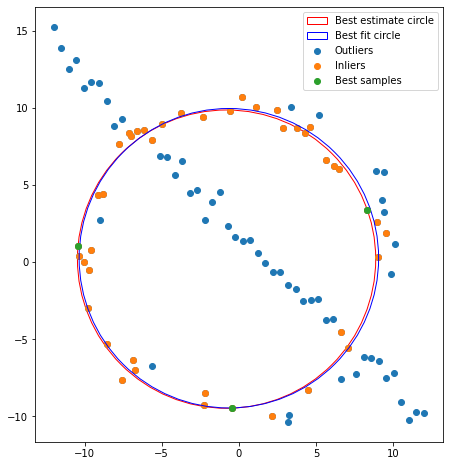

In [62]:
import numpy as np
from scipy . optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
points_of_circle,best_Inliers=ransacCircle(X,50,1,35)   #RANSAC for full data set       
c1=plotCiircle(points_of_circle,X)#plot circle
fig,ax=plt.subplots(figsize=(8,8))
ax.set_aspect( 1 )
ax.add_artist( c1 )
p1=ax.scatter(X[:,0],X[:,1])#plot all points
p2=ax.scatter(best_Inliers[:,0],best_Inliers[:,1])#plot inliers
bestfit,inl=ransacCircle(best_Inliers,50,1,len(best_Inliers)/1.2)# RANSAC for inliers
c2=plotCiircle(bestfit,best_Inliers,'b')#plot best fit circle
ax.add_artist( c2 )
Y=np.vstack((X[points_of_circle[0]],X[points_of_circle[1]],X[points_of_circle[2]]))#plot best samples
p3=ax.scatter(Y[:,0],Y[:,1])
plt.legend(handles=[c1, c2,p1,p2,p3],labels=['Best estimate circle','Best fit circle','Outliers','Inliers','Best samples'])
plt.show()

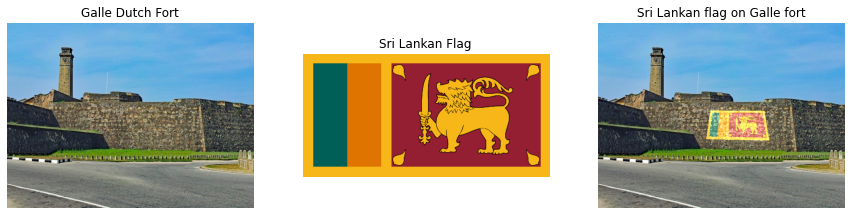

In [129]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

count = 0
point_lst = []


def getPoints(event, x, y, flags, params):
    #This function appends clicking points to the point list
    global count,point_lst
    if count < 4:
        if event == cv.EVENT_LBUTTONDOWN:#identify left mouse click
            point_lst.append((x, y))
            count += 1
    if count==4:#After entering 4 points image window closes.
        cv.waitKey(1)
        cv.destroyAllWindows()
def arrange(data):
    #This function identify left,right corners of clicking points and arrange them to calculate homography matrix.
    data.sort(reverse=0)
    if data[0][1]>data[1][1]:
        data.insert(0,data.pop(1)) #left bottom
    if data[2][1]>data[3][1]:
        data.insert(3,data.pop(2)) #right top
    data.insert(1,data.pop(2))
    return data

#read images
img1 = cv.imread(r'galle fort.jpg', cv.IMREAD_COLOR)
img2 = cv.imread(r'Flag_of_Sri_Lanka.png', cv.IMREAD_REDUCED_COLOR_4)


cv.imshow("image1", img1)#show image
cv.setMouseCallback("image1", getPoints) #get clicking points from user.
cv.waitKey(0)


src_pts = np.array([[0,0], [img2.shape[1],0], [0, img2.shape[0]], [img2.shape[1],img2.shape[0]]]) 
# arrange points to calculate homography matrix
dst_pts = np.array(arrange(point_lst))



h , status = cv.findHomography(src_pts,dst_pts,cv.RANSAC, 3)#find Homography
img_warp = cv.warpPerspective(img2, h, (img1.shape[1], img1.shape[0]))#find warp image
img_blend = cv.addWeighted(img1, 1, img_warp, 0.75, 0)#blend two images


#plot images
fig, ax = plt.subplots(1,3, figsize = (15,10))
ax[0].imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
ax[0].set_title("Galle Dutch Fort")
ax[0].axis('off') 
ax[1].imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
ax[1].set_title("Sri Lankan Flag")
ax[1].axis('off') 
ax[2].imshow(cv.cvtColor(img_blend, cv.COLOR_BGR2RGB))
ax[2].set_title("Sri Lankan flag on Galle fort")
ax[2].axis('off')
plt.show() 

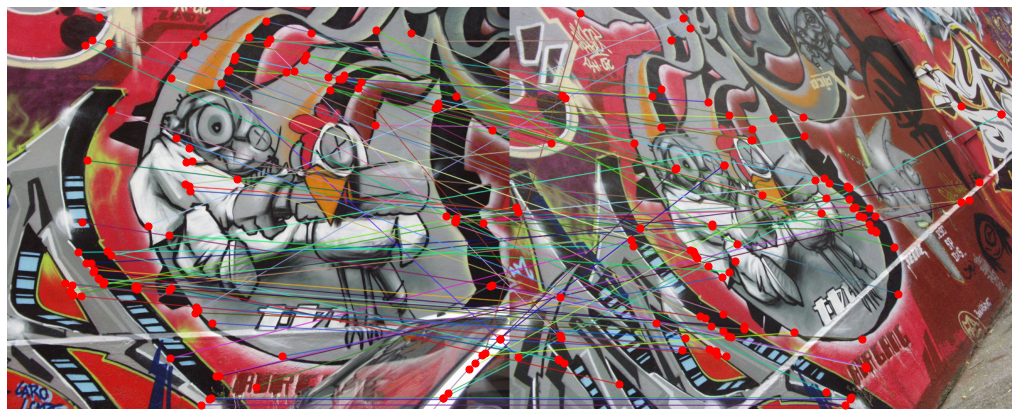

In [139]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

#read images
img1 = cv.imread(r"graf\img1.ppm", cv.IMREAD_COLOR)
img2 = cv.imread(r"graf\img4.ppm", cv.IMREAD_COLOR)
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

#create SIFT object
sift = cv.SIFT_create(contrastThreshold=0.08,edgeThreshold =5,sigma = 0.5)
keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None)#find keypoints
keypoints_2, descriptors_2 = sift.detectAndCompute(img2, None)
#match SIFT features
bf = cv.BFMatcher(cv.NORM_L1, crossCheck = True)
matches = bf.match(descriptors_1, descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)
#draw Matches
img3 = cv.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[0:100], None, flags =2)
fig, ax = plt.subplots(1,1, figsize = (18, 18))
plt.imshow(img3)

for i in range(0,100):
    plt.scatter(keypoints_1[matches[i].queryIdx].pt[0], keypoints_1[matches[i].queryIdx].pt[1], s=50, c='red', marker='o')
    plt.scatter(keypoints_2[matches[i].trainIdx].pt[0]+800, keypoints_2[matches[i].trainIdx].pt[1], s=50, c='red', marker='o')
plt.axis('off')
plt.show()


In [173]:
import cv2
import numpy as np
import getopt
import sys
import random
def calcHomography(correspondences):
    #loop through correspondences and create assemble matrix
    aList = []
    for corr in correspondences:
        Source = np.matrix([corr.item(0), corr.item(1), 1])
        Traget = np.matrix([corr.item(2), corr.item(3), 1])
        row1 = [-Traget.item(2) *Source.item(0), -Traget.item(2) *Source.item(1), -Traget.item(2) *Source.item(2), 0, 0, 0,
              Traget.item(0) *Source.item(0), Traget.item(0) *Source.item(1), Traget.item(0) *Source.item(2)]
        row2 = [0, 0, 0, -Traget.item(2) *Source.item(0), -Traget.item(2) *Source.item(1), -Traget.item(2) *Source.item(2),
              Traget.item(1) *Source.item(0), Traget.item(1) *Source.item(1), Traget.item(1) *Source.item(2)]
        
        aList.append(row1)
        aList.append(row2)

    matrixA = np.matrix(aList)

    #svd composition
    u, s, v = np.linalg.svd(matrixA)

    #reshape the min singular value into a 3 by 3 matrix
    h = np.reshape(v[8], (3, 3))

    #normalize and now we have h
    h = (1/h.item(8)) * h
    return h


#
#Calculate the geometric distance between estimated points and original points
#
def geometricDistance(correspondence, h):

    Source = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimateTraget = np.dot(h,Source)
    estimateTraget = (1/estimateTraget.item(2))*estimateTraget

    Traget = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = Traget - estimateTraget
    return np.linalg.norm(error)



def ransac(corr, thresh):
    maxInliers = []
    
    for i in range(1000):
        rndPoints=np.random.choice(len(corr), size=4, replace=False)
        randomFour = np.array([corr[x] for x in rndPoints])
        #call the homography function 
        h = calcHomography(randomFour)
        inliers = []

        for i in range(len(corr)):
            d = geometricDistance(corr[i], h)
            if d < 5:
                inliers.append(corr[i])

        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            homography_Matrix = h
        
        if len(maxInliers) > (len(corr)*thresh):
            break
    return homography_Matrix



        
    

In [175]:
import cv2 as cv
import numpy as np
import getopt
import sys
import random

def homographyMatrix(im1,im2):
      
    correspondpoints = []
    #read images
    img1 = cv.imread(im1,cv.IMREAD_ANYCOLOR)
    img2 = cv.imread(im2,cv.IMREAD_ANYCOLOR)
    img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
    img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
    sift = cv.SIFT_create()#create SIFT object
    keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None)#calculate keypoints and descriptors
    keypoints_2, descriptors_2 = sift.detectAndCompute(img2, None)
    bf = cv.BFMatcher(cv.NORM_L1, crossCheck = True)
    matches = bf.match(descriptors_1, descriptors_2)#match sift features
    #find corosponding query & train image coordinate of matches
    for match in matches:
        (x1, y1) = keypoints_1[match.queryIdx].pt
        (x2, y2) = keypoints_2[match.trainIdx].pt
        correspondpoints.append([x1,y1,x2,y2])
    corrs = np.matrix(correspondpoints)

    #use ransac algorithm to calculate homography matrix
    finalH = ransac(corrs, 0.8)#my own ransac funtion
    return finalH

H1=homographyMatrix(r"graf\img1.ppm",r"graf\img2.ppm")
H2=homographyMatrix(r"graf\img2.ppm",r"graf\img3.ppm")
H3=homographyMatrix(r"graf\img3.ppm",r"graf\img4.ppm")
H4=homographyMatrix(r"graf\img4.ppm",r"graf\img5.ppm")
calculated_H1to5=H4@H3@H2@H1

given_H1to5  =np.array([[6.2544644e-01 ,  5.7759174e-02  , 2.2201217e+02],
   [2.2240536e-01 ,  1.1652147e+00 , -2.5605611e+01],
   [4.9212545e-04 , -3.6542424e-05  , 1.0000000e+00]])
diffrence=given_H1to5-calculated_H1to5
print(calculated_H1to5)
print(diffrence)

In [161]:
np.sum(abs(calculated_H1to5-given_H1to5)**2)
s = np.sum(abs((calculated_H1to5-given_H1to5)**2))
s

0.019088391456886136

((-0.5, 799.5, 639.5, -0.5),
 (-0.5, 799.5, 639.5, -0.5),
 (-0.5, 799.5, 799.5, -0.5))

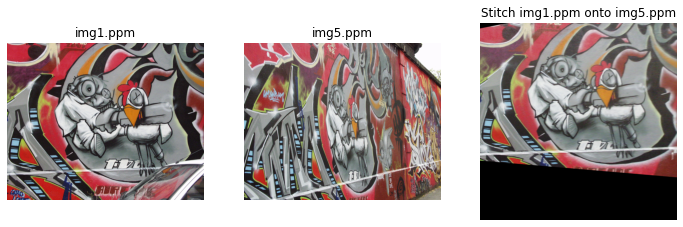

In [128]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

im1 = cv.imread(r"./graf/img1.ppm",cv.IMREAD_ANYCOLOR)
im2 = cv.imread(r"./graf/img5.ppm",cv.IMREAD_ANYCOLOR)
im1=cv.cvtColor(im1,cv.COLOR_BGR2RGB)
im2=cv.cvtColor(im2,cv.COLOR_BGR2RGB)

H=H4@H3@H2@H1

imlto4 = cv.warpPerspective(im2,np.linalg.inv(H),(800,800))


fig,ax =plt.subplots(1,3,figsize=(12,12))
ax[0].imshow(im1)
ax[0].set_title("img1.ppm")
ax[1].imshow(im4)
ax[1].set_title("img5.ppm")
ax[2].imshow(imlto4)
ax[2].set_title("Stitch img1.ppm onto img5.ppm")
ax[0].axis('off'),ax[1].axis('off'),ax[2].axis('off')
